In [1]:
fname = 'keras_67'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label, binary_erosion, binary_dilation, disk
from skimage.morphology import square, watershed, closing, binary_closing
from skimage.morphology import remove_small_holes, remove_small_objects
from skimage.filters.rank import gradient
from skimage.exposure import rescale_intensity
from skimage.segmentation import random_walker

from sklearn.model_selection import KFold

from scipy.ndimage.morphology import binary_fill_holes

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adam

import tensorflow as tf

import pickle as pkl
import gc

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = '../input/stage1_train/'
TEST_PATH = '../input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

/home/jfpuget/anaconda3/envs/tf15/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import cv2

In [4]:
import random as rn
def init_seeds(seed):
    os.environ['PYTHONHASHSEED'] = '0'

    # The below is necessary for starting Numpy generated random numbers
    # in a well-defined initial state.

    np.random.seed(seed)

    # The below is necessary for starting core Python generated random numbers
    # in a well-defined state.

    rn.seed(seed)

    # Force TensorFlow to use single thread.
    # Multiple threads are a potential source of
    # non-reproducible results.
    # For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

    from keras import backend as K

    # The below tf.set_random_seed() will make random number generation
    # in the TensorFlow backend have a well-defined initial state.
    # For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

    tf.set_random_seed(seed)

    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    return sess

In [5]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

np.random.seed(0)
perm = np.random.permutation(len(train_ids))
train_ids = [train_ids[i] for i in perm]

# Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

In [6]:
train = []
train_mask = []
test = []

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    file = "../input/stage1_train/{}/images/{}.png".format(id_,id_)
    mfile = "../input/stage1_train/{}/masks/*.png".format(id_)
    image = cv2.imread(file)
    image = rescale_intensity(image, out_range=np.uint8)
    masks = imread_collection(mfile).concatenate()
    train.append(image)
    train_mask.append(masks)
    
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    file = "../input/stage1_test/{}/images/{}.png".format(id_,id_)
    image = cv2.imread(file)
    image = rescale_intensity(image, out_range=np.uint8)
    test.append((image))
    

100%|██████████| 65/65 [00:00<00:00, 183.37it/s]


In [7]:
def to_flip(img_rgb):
    # do not flip colored images
    if (img_rgb[:,:,0] != img_rgb[:,:,1]).any():
        return img_rgb
    #green channel happends to produce slightly better results
    #than the grayscale image and other channels
    img_gray=img_rgb[:,:,1]#cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    #morphological opening (size tuned on training data)
    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    img_open=cv2.morphologyEx(img_gray, cv2.MORPH_OPEN, circle7)
    #Otsu thresholding
    img_th=cv2.threshold(img_open,0,255,cv2.THRESH_OTSU)[1]
    #Invert the image in case the objects of interest are in the dark side
    if (np.sum(img_th==255)>np.sum(img_th==0)):
        return img_rgb
    else:
        return 255 - img_rgb

In [8]:
train = [to_flip(img_rgb) for img_rgb in train]
test = [to_flip(img_rgb) for img_rgb in test]

In [9]:
def split_aux(img):
    height = img.shape[0]
    width = img.shape[1]
    if height > 2*width:
        half = int(height//2)
        return [img[:half, :, :], img[half:, :, :]]
    elif height > width:
        return [img[:width, :, :], img[height-width:, :, :]]
    elif width > 2*height:
        half = int(width//2)
        return [img[:, :half, :], img[:, half:, :]]
    else:
        return [img[:, :height, :], img[:, width-height:, :]]

def split(img):
    s = split_aux(img)
    return s

def split_mask_aux(img):
    height = img.shape[1]
    width = img.shape[2]
    if height > 2*width:
        half = int(height//2)
        return [img[:, :half, :], img[:, half:, :]]
    elif height > width:
        return [img[:, :width, :], img[:, height-width:, :]]
    elif width > 2*height:
        half = int(width//2)
        return [img[:, :, :half], img[:, :, half:]]
    else:
        return [img[:, :, :height], img[:, :, width-height:]]

def split_mask(img):
    s = split_mask_aux(img)
    return s

In [10]:
train_split = [split(img) for img in train]
train_split = [t_split[i] for t_split in train_split for i in [0, 1] ]

train_mask_split = [split_mask(img) for img in train_mask]
train_mask_split = [t_split[i] for t_split in train_mask_split for i in [0, 1] ]

test_split = [split(img) for img in test]
test_split = [t_split[i] for t_split in test_split for i in [0, 1] ]

In [12]:
# Get and resize train images and masks
X_train = np.zeros((len(train_split) * 4, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), np.uint8)
Y_train = np.zeros((len(train_split) * 4, IMG_HEIGHT, IMG_WIDTH, 1), np.uint8)
Z_train = np.zeros((len(train_split) * 4, IMG_HEIGHT, IMG_WIDTH, 3), np.uint8)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, (img, masks) in enumerate(zip(tqdm(train_split), train_mask_split)):
    img = img[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img_mean = np.mean(img, axis=2).astype(np.uint8)
    for c in range(IMG_CHANNELS):
        img[:,:,c] = img_mean
    X_train[n * 4 + 0] = img
    X_train[n * 4 + 1] = np.fliplr(img)
    X_train[n * 4 + 2] = np.flipud(img)
    X_train[n * 4 + 3] = np.flipud(np.fliplr(img))

    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_lr = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_ud = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_lr_ud = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    for mask_id in range(masks.shape[0]):
        mask_ = masks[mask_id, :, :]
        mask_ = mask_ // 255
        mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                       preserve_range=True).astype(np.uint8)
        mask = np.maximum(mask, mask_)
        mask_lr = np.maximum(mask_lr, np.fliplr(mask_))
        mask_ud = np.maximum(mask_ud, np.flipud(mask_))
        mask_lr_ud = np.maximum(mask_lr_ud, np.flipud(np.fliplr(mask_)))
        
    Y_train[4*n + 0, :, :, 0] = mask
    Y_train[4*n + 1, :, :, 0] = mask_lr
    Y_train[4*n + 2, :, :, 0] = mask_ud
    Y_train[4*n + 3, :, :, 0] = mask_lr_ud
  
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_lr = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_ud = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_lr_ud = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    for mask_id in range(masks.shape[0]):
        mask_ = masks[mask_id, :, :]
        mask_ = mask_ // 255
        mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                       preserve_range=True).astype(np.uint8)
        mask_ = binary_dilation(mask_, selem=square(3))
        mask += mask_
        mask_lr += np.fliplr(mask_)
        mask_ud += np.flipud(mask_)
        mask_lr_ud += np.flipud(np.fliplr(mask_))
        
    Z_train[4*n + 0, :, :, 0] = (mask > 1)
    Z_train[4*n + 1, :, :, 0] = (mask_lr > 1)
    Z_train[4*n + 2, :, :, 0] = (mask_ud > 1)
    Z_train[4*n + 3, :, :, 0] = (mask_lr_ud > 1)


Getting and resizing train images and masks ... 


100%|██████████| 1328/1328 [05:26<00:00,  3.88it/s]


In [13]:
for i in tqdm(range(len(train_split) * 4)):
    Z_train[i, :, :, 1] = Y_train[i, :, :, 0]
    Z_train[i, :, :, 2] = np.where(Z_train[i, :, :, 0] == 1, 0, 1 - Y_train[i, :, :, 0])

100%|██████████| 5312/5312 [00:00<00:00, 7912.15it/s]


In [14]:
# Get and resize test images and masks
X_test = np.zeros((len(test_split) * 4, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), np.uint8)
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, img in enumerate(tqdm(test_split)):
    img = img[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img_mean = np.mean(img, axis=2).astype(np.uint8)
    for c in range(IMG_CHANNELS):
        img[:,:,c] = img_mean
    X_test[n * 4 + 0] = img
    X_test[n * 4 + 1] = np.fliplr(img)
    X_test[n * 4 + 2] = np.flipud(img)
    X_test[n * 4 + 3] = np.flipud(np.fliplr(img))    

Getting and resizing test images ... 


100%|██████████| 130/130 [00:00<00:00, 142.44it/s]


In [23]:
with open('../data/X_train_%s.pkl' % fname, 'wb') as file:
    pkl.dump(X_train, file, protocol=pkl.HIGHEST_PROTOCOL)

with open('../data/Z_train_%s.pkl' % fname, 'wb') as file:
    pkl.dump(Z_train, file, protocol=pkl.HIGHEST_PROTOCOL)

with open('../data/X_test_%s.pkl' % fname, 'wb') as file:
    pkl.dump(X_test, file, protocol=pkl.HIGHEST_PROTOCOL)

In [11]:
with open('../data/X_train_%s.pkl' % fname, 'rb') as file:
    X_train= pkl.load(file)

with open('../data/Z_train_%s.pkl' % fname, 'rb') as file:
    Z_train = pkl.load(file)

with open('../data/X_test_%s.pkl' % fname, 'rb') as file:
    X_test = pkl.load(file)

Let's see if things look all right by drawing some random images and their associated masks.

23 (256, 256, 3)


/home/jfpuget/anaconda3/envs/tf15/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/jfpuget/anaconda3/envs/tf15/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


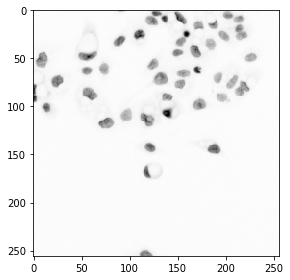

184 (256, 256, 3)


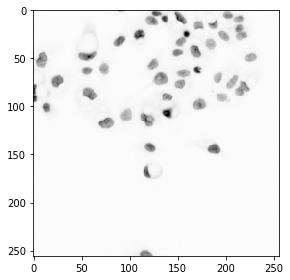

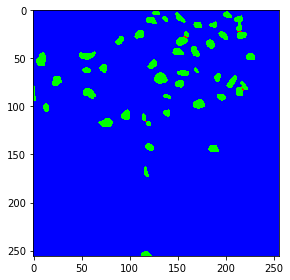

185 (256, 256, 3)


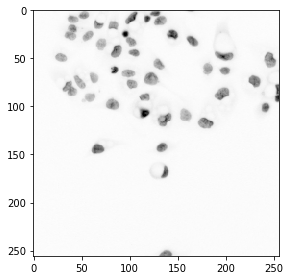

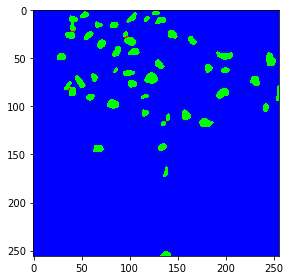

In [12]:
# Check if training data looks all right
ix = 23#random.randint(0, len(train_ids))
print(ix, train[ix].shape)
imshow(train[ix])
plt.show()

for i in range(8*ix, 8*ix + 2):
    print(i, X_train[i].shape)
    imshow(X_train[i])
    plt.show()
    imshow(255*Z_train[i])
    plt.show()

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [13]:
import keras.backend as K

def pixelwise_crossentropy(target, output):
    _epsilon = 10e-8
    output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
    weight = 30 * target[:,:,:,0:1] + 3 * target[:,:,:,1:2] + 1 * target[:,:,:,2:3]
    return - tf.reduce_sum(target * weight *  tf.log(output) +
                           (1 - target)  *  tf.log(1 - output),
                           len(output.get_shape()) - 1)


In [14]:
from keras.engine import Layer
from keras import backend as K

class SpeckleNoise(Layer):
    """Apply multiplicative one-centered Gaussian noise.
    This is useful to mitigate overfitting
    (you could see it as a form of random data augmentation).
    Speckle Noise (GS) is a natural choice as corruption process
    for real valued inputs.
    As it is a regularization layer, it is only active at training time.
    # Arguments
        stddev: float, standard deviation of the noise distribution.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as input.
    """

#    @interfaces.legacy_specklenoise_support
    def __init__(self, stddev, **kwargs):
        super(SpeckleNoise, self).__init__(**kwargs)
        self.supports_masking = True
        self.stddev = stddev

    def call(self, inputs, training=None):
        def noised():
            return K.clip(inputs * K.random_normal(shape=K.shape(inputs),
                                            mean=1.,
                                            stddev=self.stddev), 0.0, 1.0)
        return K.in_train_phase(noised, inputs, training=training)

    def get_config(self):
        config = {'stddev': self.stddev}
        base_config = super(SpeckleNoise, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [40]:
# Build U-Net model
def get_model(verbose=False):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    
    s = SpeckleNoise(0.01)(s)  #skimage speckel var defaults to 0.01

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    optimizer = Adam(clipvalue=5)
    model.compile(optimizer=optimizer, loss=pixelwise_crossentropy)
    if verbose:
        model.summary()
    return model

*Update: Changed to ELU units, added dropout.*

Next we fit the model on the training data, using a validation split of 0.1. We use a small batch size because we have so little data. I recommend using checkpointing and early stopping when training your model. I won't do it here to make things a bit more reproducible (although it's very likely that your results will be different anyway). I'll just train for 10 epochs, which takes around 10 minutes in the Kaggle kernel with the current parameters. 

*Update: Added early stopping and checkpointing and increased to 30 epochs.*

In [41]:
try:
    sess.close()
except:
    pass

sess = init_seeds(0)

# even number of folds because we duplicate images
kf = KFold(6, shuffle=False)

models = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print('*' * 40)
    print('Fold:', fold)
    X_train_kf = X_train[train_idx]
    X_val_kf = X_train[val_idx]
    Z_train_kf = Z_train[train_idx]
    Z_val_kf = Z_train[val_idx]

    model = get_model(verbose=(fold==0))
    models.append(model)

    # Fit model
    earlystopper = EarlyStopping(patience=5, verbose=1)
    checkpointer = ModelCheckpoint('model_%s_%d.h5' % (fname, fold), 
                                   verbose=1, save_best_only=True)
    results = model.fit(X_train_kf, Z_train_kf, 
                        validation_data = (X_val_kf, Z_val_kf),
                        batch_size=2, epochs=40, shuffle=True,
                        callbacks=[earlystopper, checkpointer])

#sess.close()

****************************************
Fold: 0
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 256, 256, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
speckle_noise_7 (SpeckleNoise)  (None, 256, 256, 3)  0           lambda_7[0][0]                   
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 256, 256, 16) 448         speckle_noise_7[0][0]            
____________________________________________________________

Train on 4426 samples, validate on 886 samples
Epoch 1/40
4426/4426 [==============================] - 58s 13ms/step - loss: 0.5669 - val_loss: 0.4517

Epoch 00001: val_loss improved from inf to 0.45167, saving model to model_keras_67_0.h5
Epoch 2/40
4426/4426 [==============================] - 55s 12ms/step - loss: 0.3657 - val_loss: 0.3894

Epoch 00002: val_loss improved from 0.45167 to 0.38938, saving model to model_keras_67_0.h5
Epoch 3/40
4426/4426 [==============================] - 55s 12ms/step - loss: 0.3381 - val_loss: 0.4407

Epoch 00003: val_loss did not improve
Epoch 4/40
4426/4426 [==============================] - 55s 12ms/step - loss: 0.3342 - val_loss: 0.3508

Epoch 00004: val_loss improved from 0.38938 to 0.35080, saving model to model_keras_67_0.h5
Epoch 5/40
4426/4426 [==============================] - 55s 12ms/step - loss: 0.3116 - val_loss: 0.3503

Epoch 00005: val_loss improved from 0.35080 to 0.35032, saving model to model_keras_67_0.h5
Epoch 6/40
4426/4426 [====

Epoch 2/40
4427/4427 [==============================] - 56s 13ms/step - loss: 0.4084 - val_loss: 0.3807

Epoch 00002: val_loss improved from 0.77024 to 0.38069, saving model to model_keras_67_2.h5
Epoch 3/40
4427/4427 [==============================] - 56s 13ms/step - loss: 0.3516 - val_loss: 0.3064

Epoch 00003: val_loss improved from 0.38069 to 0.30643, saving model to model_keras_67_2.h5
Epoch 4/40
4427/4427 [==============================] - 56s 13ms/step - loss: 0.3036 - val_loss: 0.2513

Epoch 00004: val_loss improved from 0.30643 to 0.25130, saving model to model_keras_67_2.h5
Epoch 5/40
4427/4427 [==============================] - 56s 13ms/step - loss: 0.3164 - val_loss: 0.2642

Epoch 00005: val_loss did not improve
Epoch 6/40
4427/4427 [==============================] - 56s 13ms/step - loss: 0.2645 - val_loss: 0.2412

Epoch 00006: val_loss improved from 0.25130 to 0.24119, saving model to model_keras_67_2.h5
Epoch 7/40
4427/4427 [==============================] - 56s 13ms/step

4427/4427 [==============================] - 55s 12ms/step - loss: 0.2477 - val_loss: 0.2236

Epoch 00008: val_loss improved from 0.23640 to 0.22365, saving model to model_keras_67_4.h5
Epoch 9/40
4427/4427 [==============================] - 55s 12ms/step - loss: 0.2338 - val_loss: 0.2320

Epoch 00009: val_loss did not improve
Epoch 10/40
4427/4427 [==============================] - 55s 12ms/step - loss: 0.2328 - val_loss: 0.2205

Epoch 00010: val_loss improved from 0.22365 to 0.22049, saving model to model_keras_67_4.h5
Epoch 11/40
4427/4427 [==============================] - 55s 12ms/step - loss: 0.2287 - val_loss: 0.2267

Epoch 00011: val_loss did not improve
Epoch 12/40
4427/4427 [==============================] - 55s 12ms/step - loss: 0.2231 - val_loss: 0.2172

Epoch 00012: val_loss improved from 0.22049 to 0.21720, saving model to model_keras_67_4.h5
Epoch 13/40
4427/4427 [==============================] - 55s 12ms/step - loss: 0.2191 - val_loss: 0.2192

Epoch 00013: val_loss did

All right, looks good! Loss seems to be a bit erratic, though. I'll leave it to you to improve the model architecture and parameters! 

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [15]:
try:
    sess.close()
except:
    pass

sess = init_seeds(0)

# even number of folds because we duplicate images
kf = KFold(6, shuffle=False)


In [16]:
preds_train = np.zeros(Z_train.shape)
preds_test = 0
# Predict on train, val and test
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    model = load_model('model_%s_%d.h5' % (fname, fold), 
                       custom_objects={'pixelwise_crossentropy':pixelwise_crossentropy,
                                       'SpeckleNoise':SpeckleNoise,
                                      })
    X_val_kf = X_train[val_idx]
    preds_train[val_idx] = model.predict(X_val_kf, verbose=1)
    preds_test += model.predict(X_test, verbose=1)
preds_test /= 6

520/520 [==============================] - 1s 3ms/step


In [17]:
# Create list of upsampled train preds
preds_train_upsampled = []
for i in tqdm(range(len(train_split))):
    train_i = train_split[i]
    shape = (train_i.shape[0], train_i.shape[1], 3)
    pred = resize((preds_train[4*i + 0]), 
                  shape, 
                  mode='constant', preserve_range=True)
    pred += np.fliplr(resize((preds_train[4*i + 1]), 
                  shape, 
                  mode='constant', preserve_range=True))
    pred += np.flipud(resize((preds_train[4*i + 2]), 
                  shape, 
                  mode='constant', preserve_range=True))
    pred += np.flipud(np.fliplr(resize((preds_train[4*i + 3]), 
                  shape, 
                  mode='constant', preserve_range=True)))
    #pred = (pred > 4*threshold).astype(np.uint8)
    pred /= 4
    preds_train_upsampled.append(pred)

100%|██████████| 1328/1328 [00:50<00:00, 26.16it/s]


In [18]:
def merge(img1, img2, shape):
    ov2 = 5
    height = shape[0]
    width = shape[1]
    img = np.zeros((height, width, 3), dtype=np.float32)
    w = np.zeros((height, width, 1), dtype=np.float32)
    height1 = img1.shape[0]
    width1 = img1.shape[1]
    height2 = img2.shape[0]
    width2 = img2.shape[1]  
    w1 = 10*ov2*np.ones((height1, width1, 1), dtype=np.float32)
    w2 =  10*ov2*np.ones((height2, width2, 1), dtype=np.float32)
    for i in range(ov2, 0, -1):
        w1[i-1,:] = 10*i
        w1[height1 - i, :] = 10*i
        w1[:, i-1] = 10*i
        w1[:, width1 - i] = 10*i
        w2[i-1,:] = 10*i
        w2[height2 - i, :] = 10*i
        w2[:, i-1] = 10*i
        w2[:, width2 - i] = 10*i

    if height > 2*width:
        half = int(height//2)
        img[:half, :, :] += w1*img1
        img[half:, :, :] += w2*img2
        w[:half, :] += w1
        w[half:, :] += w2
        img /= w
    elif height > width:
        img[:width, :, :] += w1*img1
        img[height-width:, :, :] += w2*img2
        w[:width, :] += w1
        w[height-width:, :] += w2
        img /= w
    elif width > 2*height:
        half = int(width//2)
        img[:, :half, :] += w1*img1
        img[:, half:, :] += w2*img2
        w[:, :half] += w1
        w[:, half:] += w2
        img /= w
    else:
        img[:, :height, :] += w1*img1 
        img[:, width-height:, :] += w2*img2
        w[:, :height] += w1 
        w[:, width-height:] += w1
        img /= w
    return (255*img).astype(np.uint8)

In [19]:
preds_train_merged = []
for ix in tqdm(range(len(train))):    
    merged = merge(preds_train_upsampled[2*ix+0], 
             preds_train_upsampled[2*ix+1],
             train[ix].shape
            )
    preds_train_merged.append(merged)

100%|██████████| 664/664 [00:02<00:00, 262.18it/s]


In [20]:
preds_test_upsampled = []
for i in tqdm(range(len(test_split))):
    test_i = test_split[i]
    pred = resize(np.squeeze(preds_test[4*i + 0]), 
                  (test_i.shape[0], test_i.shape[1]), 
                  mode='constant', preserve_range=True)
    pred += np.fliplr(resize(np.squeeze(preds_test[4*i + 1]), 
                  (test_i.shape[0], test_i.shape[1]), 
                  mode='constant', preserve_range=True))
    pred += np.flipud(resize(np.squeeze(preds_test[4*i + 2]), 
                  (test_i.shape[0], test_i.shape[1]), 
                  mode='constant', preserve_range=True))
    pred += np.flipud(np.fliplr(resize(np.squeeze(preds_test[4*i + 3]), 
                  (test_i.shape[0], test_i.shape[1]), 
                  mode='constant', preserve_range=True)))
    #pred = (pred > 4*threshold).astype(np.uint8)
    pred /= 4
    preds_test_upsampled.append(pred)


100%|██████████| 130/130 [00:05<00:00, 25.52it/s]


In [21]:
preds_test_merged = []
for ix in tqdm(range(len(test))):    
    merged = merge(preds_test_upsampled[2*ix+0], 
                 preds_test_upsampled[2*ix+1],
                 test[ix].shape
            )
    preds_test_merged.append(merged)

100%|██████████| 65/65 [00:00<00:00, 196.15it/s]


/home/jfpuget/anaconda3/envs/tf15/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/jfpuget/anaconda3/envs/tf15/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


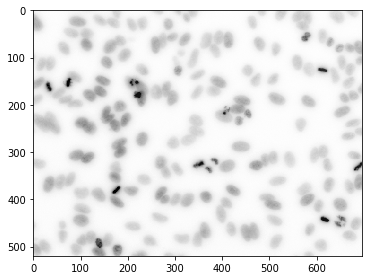

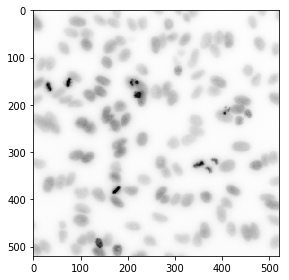

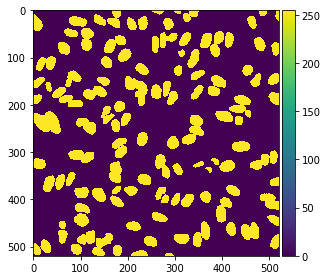

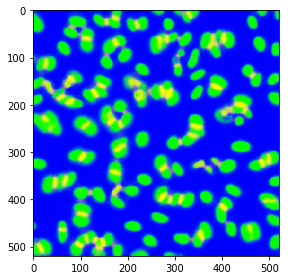

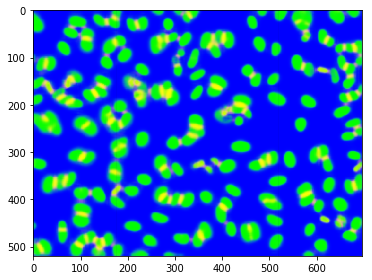

In [22]:
ix = 17
imshow(train[ix])
plt.show()

imshow(train_split[2*ix+0])
plt.show()

imshow(np.sum(train_mask_split[2*ix+0], axis=0))
plt.show()

imshow((preds_train_upsampled[2*ix+0]))
plt.show()
imshow(merge(preds_train_upsampled[2*ix+0], 
             preds_train_upsampled[2*ix+1],
             train[ix].shape
            ))
plt.show()

In [23]:
from skimage.morphology import label

def get_labels(y):
    labels = np.zeros((y.shape[1], y.shape[2]))
    for i in range(y.shape[0]):
        labels = np.where(y[i,:,:] > 0, i+1, labels)
    return labels

def iou_score_cuk(y_true, y_pred, verbose=True, thresholds=np.arange(0.5, 1.0, 0.05)):
    y_true = get_labels(y_true)
    y_pred = get_labels(y_pred)
    # Compute number of objects
    true_objects = len(np.unique(y_true))
    pred_objects = len(np.unique(y_pred))
    if verbose:
        print("Number of true objects:", true_objects - 1)
        print("Number of predicted objects:", pred_objects - 1)
    
    intersection = np.histogram2d(y_true.flatten(), y_pred.flatten(), 
                                  bins=(true_objects, pred_objects))[0].astype('int')

    area_true = np.histogram(y_true, bins = true_objects)[0]
    area_true = np.expand_dims(area_true, -1)

    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_pred = np.expand_dims(area_pred, 0)

    union = area_true + area_pred - intersection
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9
    
    iou = intersection / union
    
    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn    
    
    prec = []
    
    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in thresholds:
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) == 0:
            p = 1
        else:
            p = tp / (tp + fp + fn)
        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

In [24]:
from scipy.ndimage.morphology import binary_fill_holes

def get_pred_watershed(upsampled, area_threshold, threshold, sep_threshold, 
             spread_threshold, alpha, connectivity=2):
    img = ((upsampled[:,:,1] > 255 * threshold) &
                    (upsampled[:,:,0] < 255 * sep_threshold))
    img = binary_fill_holes(img)
    img = remove_small_objects(img, area_threshold)
    lab_img = label(img, connectivity=connectivity)
    distance = upsampled[:,:,1] + alpha * upsampled[:,:,0]
    img = 1 * ((distance > 255 * spread_threshold) )
    
    lab_img = img * watershed(- upsampled[:,:,1], lab_img)

    y_pred = np.zeros((lab_img.max(), lab_img.shape[0], lab_img.shape[1]), np.uint16)
    i = 0
    for lab in range(lab_img.max()):
        tmp = (lab_img == lab+1)
        if np.sum(tmp.ravel()) > area_threshold:
            y_pred[i,:,:] = tmp
            i += 1
    return y_pred[:i]

from scipy.ndimage.morphology import binary_fill_holes

def get_pred_random_walker(upsampled, area_threshold, threshold, sep_threshold, 
             spread_threshold, alpha, connectivity=2):
    img = ((upsampled[:,:,1] > 255 * threshold) &
                    (upsampled[:,:,0] < 255 * sep_threshold))
    
    img = binary_fill_holes(img)
    img = remove_small_objects(img, area_threshold)
    markers = label(img, connectivity=connectivity)
    distance = upsampled[:,:,1] + alpha * upsampled[:,:,0]
    mask = ((distance > 255 * spread_threshold) )
    markers[~mask] = -1
    
    lab_img = random_walker(mask, markers)

    y_pred = np.zeros((lab_img.max(), lab_img.shape[0], lab_img.shape[1]), np.uint16)
    i = 0
    for lab in range(lab_img.max()):
        tmp = (lab_img == lab+1)
        if np.sum(tmp.ravel()) > area_threshold:
            y_pred[i,:,:] = tmp
            i += 1
    return y_pred[:i]

def get_pred(upsampled, area_threshold, threshold, sep_threshold, 
             spread_threshold, alpha, connectivity=2):
    try:
        return get_pred_random_walker(upsampled, area_threshold, threshold, 
                                          sep_threshold, spread_threshold, 
                                      alpha, connectivity)
    except:
        return get_pred_watershed(upsampled, area_threshold, threshold, 
                                          sep_threshold, spread_threshold, 
                                      alpha, connectivity)
        

In [25]:
area_threshold = 20
threshold = 0.75
sep_threshold = 0.6
spread_threshold = 0.4
alpha=0.4

def get_pred(upsampled, area_threshold=area_threshold, 
             threshold=threshold, sep_threshold=sep_threshold, 
             spread_threshold=spread_threshold, alpha=alpha, connectivity=2):
    try:
        return get_pred_random_walker(upsampled, area_threshold, threshold, 
                                          sep_threshold, spread_threshold, 
                                      alpha, connectivity=2)
    except:
        return get_pred_watershed(upsampled, area_threshold, threshold, 
                                          sep_threshold, spread_threshold, 
                                      alpha, connectivity=2)

In [26]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths
            
def pred_to_rles(y_pred):
    for i in range(y_pred.shape[0]):
        tmp = y_pred[i]
        yield rle_encoding(tmp)


In [27]:
score = np.zeros(len(train))

new_train_ids = []
rles = []
                 
for n, id_ in enumerate(tqdm(train_ids)):  
    y_pred = get_pred(preds_train_merged[n])
    score[n] = iou_score_cuk(train_mask[n], y_pred, verbose=False)
    rle = list(pred_to_rles(y_pred))
    rles.extend(rle)
    new_train_ids.extend([id_] * len(rle))

print(len(rles))
    
sub = pd.DataFrame()
sub['ImageId'] = new_train_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

sub.to_csv('../submissions/keras_unet_67_train.csv', index=False)
train_score = np.mean(score)

print('%0.5f' % train_score) 

100%|██████████| 664/664 [01:55<00:00,  5.01it/s]


26893
0.55121


In [28]:
new_test_ids = []
rles = []
for n, id_ in tqdm(enumerate(test_ids)):
    y_pred = get_pred(preds_test_merged[n])
    rle = list(pred_to_rles(y_pred))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

print(len(rles))

# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('../submissions/keras_unet_67_test.csv', index=False)

65it [00:18,  3.50it/s]

3799


In [29]:
with open('../data/%s_train_pred.pkl' % fname, 'wb') as file:
    pkl.dump(preds_train_merged, file)

with open('../data/%s_test_pred.pkl' % fname, 'wb') as file:
    pkl.dump(preds_test_merged, file)